<a href="https://colab.research.google.com/github/AnuradhaRajawat/hello_/blob/main/SoundCluster.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
!pip install spotipy

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 261.3/261.3 kB 6.8 MB/s eta 0:00:00


In [9]:
!pip install matplotlib seaborn


In [21]:
!pip install pandas numpy seaborn matplotlib spotipy scikit-learn


Missing values in each column:
danceability    0
energy          0
loudness        0
valence         0
tempo           0
key             0
name            0
artists         0
dtype: int64

Basic Statistics:
       danceability    energy  loudness   valence       tempo       key
count      7.000000  7.000000  7.000000  7.000000    7.000000  7.000000
mean       0.660286  0.820714 -4.881429  0.786429  115.072429  4.000000
std        0.152500  0.138227  2.033268  0.091686   25.231467  2.886751
min        0.415000  0.604000 -8.732000  0.634000   83.648000  1.000000
25%        0.575000  0.752000 -5.325000  0.739500   95.402500  2.000000
50%        0.687000  0.860000 -5.005000  0.792000  120.042000  2.000000
75%        0.754000  0.918000 -3.777500  0.845500  130.523000  6.500000
max        0.862000  0.941000 -2.228000  0.909000  149.966000  8.000000


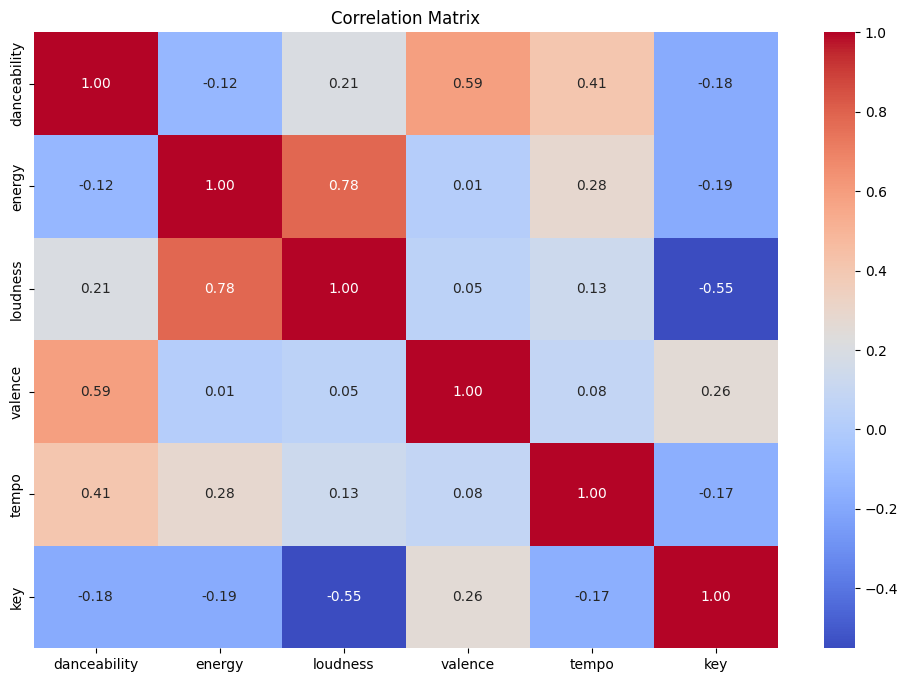

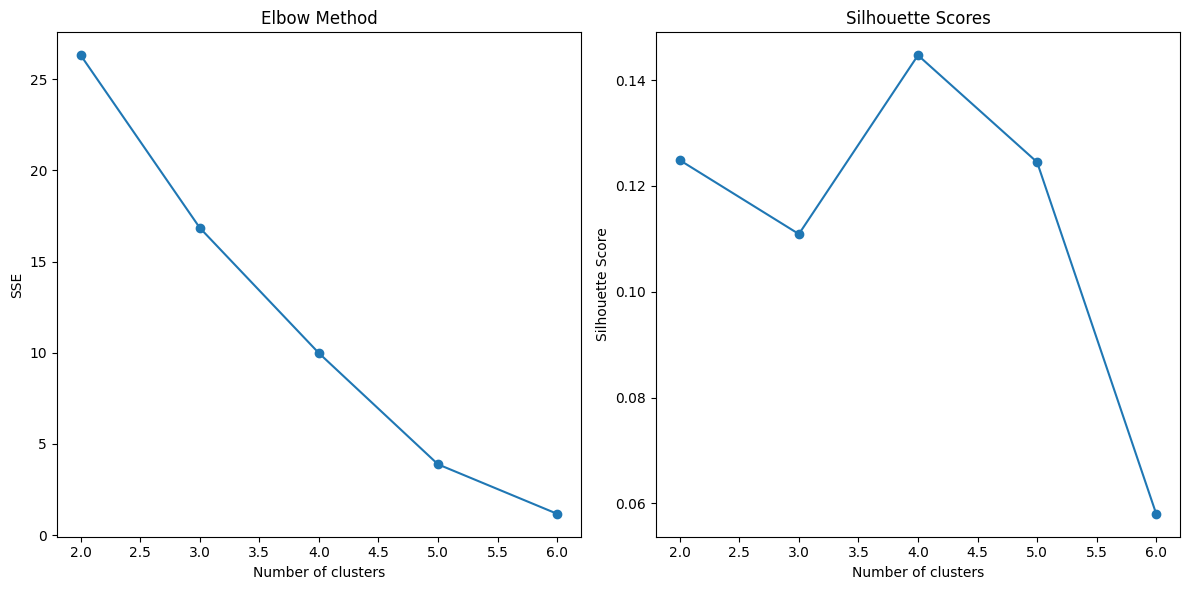


Recommended Songs for Cluster 0:
 - Tujh Mein Rab Dikhta Hai by Salim–Sulaiman, Roop Kumar Rathod, Jaideep Sahni (Cluster 0)
 - Aayi Nai (From "Stree 2") by Sachin-Jigar, Pawan Singh, Simran Choudhary, Divya Kumar, Amitabh Bhattacharya (Cluster 0)

Recommended Songs for Cluster 1:
 - Haan Tu Hain by Pritam, KK (Cluster 1)

Recommended Songs for Cluster 2:
 - Tu Jaane Na by Atif Aslam, Pritam (Cluster 2)
 - Badtameez Dil by Pritam, Benny Dayal, Shefali Alvares (Cluster 2)
 - Dilliwaali Girlfriend by Pritam, Arijit Singh, Sunidhi Chauhan (Cluster 2)

Recommended Songs for Cluster 3:
 - Dil Ibaadat by Pritam, KK (Cluster 3)


In [36]:
import pandas as pd
import numpy as np
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import silhouette_score
import matplotlib.pyplot as plt
import seaborn as sns
import spotipy
from spotipy.oauth2 import SpotifyClientCredentials

# Step 1: Authentication
client_id = '1d8b9142a84042bf9ea4db27b428665f'
client_secret = 'abfb65f2173a41c8821815cdbf9a9cd8'

# Authenticate to Spotify
credentials = SpotifyClientCredentials(client_id=client_id, client_secret=client_secret)
sp = spotipy.Spotify(client_credentials_manager=credentials)

# Step 2: Define track IDs
track_ids = [
    '5vGiuYFSGekGLgbxhV1rD5',
    '2LcXJP95e4HKydTZ2mYfrx',
    '1mQUEvGR7Sbt2OCz2gFrdx',
    '3Kl8p2PxVf8eAayLwTxOIm',
    '4vgCpNUUcpEIBifidhQOnR',
    '4eu27jAU2bbnyHUC3G75U8',
    '3W1XPf7mvuQcWQB7U7MbTM'
]

# Step 3: Fetch audio features from Spotify
features = []
song_names = []
artists = []

for track_id in track_ids:
    audio_features = sp.audio_features(track_id)[0]  # Fetch audio features for each track
    if audio_features:  # Check if features were returned
        features.append(audio_features)

        # Fetch track details (name and artist)
        track_info = sp.track(track_id)
        song_names.append(track_info['name'])
        artists.append([artist['name'] for artist in track_info['artists']])

# Create a DataFrame with the relevant audio features
feature_data = {
    'danceability': [f['danceability'] for f in features],
    'energy': [f['energy'] for f in features],
    'loudness': [f['loudness'] for f in features],
    'valence': [f['valence'] for f in features],
    'tempo': [f['tempo'] for f in features],
    'key': [f['key'] for f in features],
}

df_features = pd.DataFrame(feature_data)

# Add song names and artists to the DataFrame
df_features['name'] = song_names
df_features['artists'] = artists

# Step 4: EDA
# Check for missing values
print("Missing values in each column:")
print(df_features.isnull().sum())

# Display basic statistics
print("\nBasic Statistics:")
print(df_features.describe())

# Correlation matrix (only for numeric columns)
plt.figure(figsize=(12, 8))
correlation_matrix = df_features[['danceability', 'energy', 'loudness', 'valence', 'tempo', 'key']].corr()
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Matrix')
plt.show()

# Step 5: Feature Engineering
# Normalizing the data
scaler = StandardScaler()
df_scaled = scaler.fit_transform(df_features[['danceability', 'energy', 'loudness', 'valence', 'tempo']])

# Step 6: Determine optimal number of clusters
sse = []
silhouette_scores = []
max_clusters = min(len(df_scaled) - 1, 10)  # Ensure k is less than n_samples

for k in range(2, max_clusters + 1):
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(df_scaled)
    sse.append(kmeans.inertia_)

    # Compute silhouette score only if there are at least 2 clusters
    if k > 1:
        silhouette_scores.append(silhouette_score(df_scaled, kmeans.labels_))

# Plot the elbow method
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(range(2, max_clusters + 1), sse, marker='o')
plt.title('Elbow Method')
plt.xlabel('Number of clusters')
plt.ylabel('SSE')

# Plot silhouette scores
plt.subplot(1, 2, 2)
plt.plot(range(2, max_clusters + 1), silhouette_scores, marker='o')
plt.title('Silhouette Scores')
plt.xlabel('Number of clusters')
plt.ylabel('Silhouette Score')

plt.tight_layout()
plt.show()

# Choose optimal number of clusters (adjust this based on the plots)
optimal_k = 4  # Change based on the results from the plots
kmeans = KMeans(n_clusters=optimal_k, random_state=42)
kmeans.fit(df_scaled)

# Step 7: Add cluster labels to the original DataFrame
df_features['Cluster'] = kmeans.labels_

# Step 8: Display the results in a detailed format
recommendations = {}

for cluster in range(optimal_k):
    cluster_songs = df_features[df_features['Cluster'] == cluster]
    recommendations[cluster] = cluster_songs

    print(f"\nRecommended Songs for Cluster {cluster}:")
    for index, row in cluster_songs.iterrows():
        # Display the song name, artist, and cluster
        song_name = row['name']
        song_artists = ', '.join(row['artists'])
        print(f" - {song_name} by {song_artists} (Cluster {cluster})")
